<h1>&nbsp;&nbsp;&nbsp;&nbsp;Introduction</h1>
   
``` 
This notebook details the step taken to rank the best college towns for remote workers in the United States.

Methodology & Sources: 

The data used was collected from different sources; 
The list of college towns was gotten from wikipedia (https://en.wikipedia.org/wiki/List_of_college_towns#United_States),
The internet speed was obtained from Speedtest(speedtest.net)
Some demographic data(population,median income etc.) was obtained from Bestplaces(https://www.bestplaces.net)
Walkscore and Bikescore of each town was obtained from Walkscore (https://www.walkscore.com/)
Number of coworking space in each town was obtained from CityFeet(https://www.cityfeet.com/cont/coworking-space)

The data for each college town was obtained from the sites above,and the relevant attributes were normalised to bring   the attributes to same scale, using the following weights for each attributes:- Unemployment rate: 10%, Cost of living   index: 20%,Number of eateries per capita: 10%,Number of coworking spaces per capita: 10%, Median income per capita: 15%,
Speed score: 20%, Active Mobility Score: 15%.These weights were assigned based on perceived importance of the attributes to remote workers.The final ranking score was obtained using weighted sum of each score of each attributes taking into  consideration their weights. where missing data was encoutered for any town, the median value of the attribute for the  state was used.

The data was collected between 4th-7th of May,2023.


In [1]:
#necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

#imports for multi-criteria decision analysis
import skcriteria as skc #!pip install scikit-criteria to use the library
from skcriteria.madm import simple
from skcriteria.madm import similarity  # for TOPSIS
from skcriteria.pipeline import mkpipe  # for pipelines
from skcriteria.preprocessing import invert_objectives, scalers

In [2]:
#load data
town_names=pd.read_csv('./Downloads/The Best College Towns for Remote Workers Project/us_college_towns_mod.csv')
town_internet=pd.read_csv('./Downloads/The Best College Towns for Remote Workers Project/us_towns_internet_full.csv')
town_places=pd.read_csv('./Downloads/The Best College Towns for Remote Workers Project/best_places.csv')
town_walk_scores=pd.read_csv('./Downloads/The Best College Towns for Remote Workers Project/walk_score_.csv')
town_work_spaces=pd.read_csv('./Downloads/The Best College Towns for Remote Workers Project/city_feet_coworking_space.csv')

In [3]:
#create new column for town_internet to use as key for joining
town_internet['college_towns']=town_internet.apply(lambda row: row['town_name'] + ', ' + row['state_name'], axis=1)

In [4]:
#replace state in town_places with full name instead of abbrevations
# Create a dictionary of state abbreviations and full names
state_dict = {'AL': 'Alabama','AK': 'Alaska','AZ': 'Arizona','AR': 'Arkansas','CA': 'California','CO': 'Colorado',
              'CT': 'Connecticut','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','HI': 'Hawaii','ID': 'Idaho',
              'IL': 'Illinois','IN': 'Indiana','IA': 'Iowa','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana',
              'ME': 'Maine','MD': 'Maryland','MA': 'Massachusetts','MI': 'Michigan','MN': 'Minnesota','MS': 'Mississippi',
            'MO': 'Missouri','MT': 'Montana','NE': 'Nebraska','NV': 'Nevada','NH': 'New Hampshire','NJ': 'New Jersey',
              'NM': 'New Mexico','NY': 'New York','NC': 'North Carolina','ND': 'North Dakota','OH': 'Ohio','OK': 'Oklahoma',
              'OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota',
              'TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VT': 'Vermont','VA': 'Virginia','WA': 'Washington',
              'WV': 'West Virginia','WI': 'Wisconsin','WY': 'Wyoming'}

# Replace state abbreviations with full names
town_places['state'] = town_places['state'].replace(state_dict)
#create new column for town_places to use as key for joining
town_places['college_towns']=town_places.apply(lambda row: row['name'] + ', ' + row['state'], axis=1)
town_places['cost_of_living']=(town_places['cost_of_living'].str.split('%').str.get(0))
town_places['cost_of_living']=town_places['cost_of_living'].astype('float')+100

In [5]:
#to create college town column:
town_work_spaces['state']=town_work_spaces['town_name'].str.split(',').str.get(1)
town_work_spaces['town']=town_work_spaces['town_name'].str.split(',').str.get(0)
# Replace state abbreviations with full names
town_work_spaces['state']=town_work_spaces['state'].str.strip()
town_work_spaces['state'] = town_work_spaces['state'].replace(state_dict)
#create new column for town_internet to use as key for joining
town_work_spaces['college_towns']=town_work_spaces.apply(lambda row: row['town'] + ', ' + row['state'], axis=1)

In [6]:
#join town_walk_scores and town_work_spaces
town_walk_and_work_spaces=town_work_spaces.merge(town_walk_scores,left_on='town_name',right_on='town_name',how='outer')

In [7]:
#join town_places and town_internet
town_places['unemployment_rate']=(town_places['unemployment_rate'].str.split('%').str.get(0).str.strip()).astype('float')
town_places_and_internet=town_places.merge(town_internet,left_on='college_towns',right_on='college_towns',how='outer')

In [8]:
#join town_places_and_internet and town_walk_and_work_spaces
town_info_combined=town_places_and_internet.merge(town_walk_and_work_spaces,left_on='college_towns',
                                            right_on='college_towns',how='outer')

In [9]:
#join town_names and the town_info_combined into final dataset-town data
town_data=town_names.merge(town_info_combined,left_on='US college towns',
                                            right_on='college_towns',how='left')

In [10]:
#drop duplicates in final dataset
town_data.drop_duplicates(inplace=True)

In [11]:
#extract only relevant columns and rearrange column positions
town_data=town_data[['US college towns','state','population', 'unemployment_rate', 'median_income', 'median_age',
               'cost_of_living','median_download_speed', 'median_upload_speed', 'median_latency',
                'num_coworking_space', 'walk_score', 'bike_score', 'num_eateries']]
#rename columns
town_data.rename(columns={'US college towns':'College towns','population': 'Population', 'unemployment_rate':'Unemployment rate(%)', 
                          'median_income':'Median income','median_age':'Median age', 'cost_of_living':'Cost of living index(%)', 
                          'median_download_speed':'Median download speed', 'median_upload_speed':'Median upload speed', 
                          'median_latency':'Median latency','num_coworking_space':'Number of coworking space', 
                          'walk_score':'Walk score', 'bike_score':'Bike score', 'num_eateries':'Number of eateries'},inplace=True)
#reset index
town_data.reset_index(drop=True,inplace=True)

In [12]:
#remove comma in population column
town_data['Population']=town_data['Population'].str.replace(',','')
#remove dollar and comma in median income column
town_data['Median income']=town_data['Median income'].str.strip('$').str.replace(',','').str.strip()
town_data['Number of eateries']=town_data['Number of eateries'].str.replace(',','')

In [13]:
#change necessary data type
town_data['Population']=town_data['Population'].astype('float')
town_data['Median income']=town_data['Median income'].astype('float')
town_data['Number of eateries']=town_data['Number of eateries'].astype('float')


In [14]:
#list of columns with missing values
cols_with_missing_vals = ['Population', 'Unemployment rate(%)', 'Median income', 
                          'Median age', 'Cost of living index(%)', 'Median download speed', 
                          'Median upload speed', 'Median latency', 'Walk score', 'Bike score',
                          'Number of eateries']
states_names = list(state_dict.values())

# Impute missing values with median value of each state
for col in cols_with_missing_vals:
    median_col_val_per_state = town_data.groupby('state')[col].median()
    town_data.loc[town_data[col].isnull(), col] = town_data.loc[town_data[col].isnull(), 'state'].map(median_col_val_per_state)


In [15]:
#validate missing values removal
town_data.isna().sum()

College towns                0
state                        0
Population                   0
Unemployment rate(%)         0
Median income                0
Median age                   0
Cost of living index(%)      0
Median download speed        1
Median upload speed          1
Median latency               1
Number of coworking space    0
Walk score                   1
Bike score                   1
Number of eateries           1
dtype: int64

In [16]:
#check where we have this missing value
town_data[town_data['Number of eateries'].isna()]

,College towns,state,Population,Unemployment rate(%),Median income,Median age,Cost of living index(%),Median download speed,Median upload speed,Median latency,Number of coworking space,Walk score,Bike score,Number of eateries
165,"Laie, Hawaii",Hawaii,6436.0,7.6,81948.0,23.4,211.9,NaN,NaN,NaN,0.0,NaN,NaN,NaN


`All the remaining missing values come from a single row whose state is Hawaii, the reason for this remaining missing values will be checked`

In [17]:
town_data[town_data['state']=='Hawaii'].shape[0]

1

`In the data there is only one row whose state value is Hawaii, and since this singe row has missing values, there are no median value in same state to use for imputation, henece that's why missing values remains. the missing value will be imputed with the national median values`

In [18]:
#fill missing value in Laie, Hawaii with national median value
for col in cols_with_missing_vals:
    town_data[col].fillna(town_data[col].median(),inplace=True)

In [19]:
#check first 5 rows
town_data.head()

,College towns,state,Population,Unemployment rate(%),Median income,Median age,Cost of living index(%),Median download speed,Median upload speed,Median latency,Number of coworking space,Walk score,Bike score,Number of eateries
0,"Auburn, Alabama",Alabama,74637.0,2.3,37406.0,24.1,97.6,192.820,22.160,16.0,2.0,28.0,38.0,240.0
1,"Fairfield, Alabama",Alabama,10108.0,3.8,34556.0,36.8,76.2,180.565,22.835,17.0,0.0,30.0,36.5,208.5
2,"Florence, Alabama",Alabama,39709.0,3.2,35632.0,37.1,79.4,171.230,15.560,27.0,0.0,32.0,36.0,151.0
3,"Homewood, Alabama",Alabama,26206.0,1.9,62431.0,31.5,114.2,144.470,22.190,17.0,4.0,42.0,25.0,177.0
4,"Huntsville, Alabama",Alabama,210081.0,3.1,49060.0,36.9,90.7,238.980,105.610,11.0,5.0,24.0,40.0,714.0


In [20]:
#susbstitute mdian value for towns where coworking space =0 as 0 represented lack of data
town_data['Number of coworking space'].replace(0,(town_data['Number of coworking space'].median()),inplace=True)

In [21]:
#drop state column as it is not not needed again
town_data.drop('state',axis=1,inplace=True)

In [22]:
#some eda
town_data.head()

,College towns,Population,Unemployment rate(%),Median income,Median age,Cost of living index(%),Median download speed,Median upload speed,Median latency,Number of coworking space,Walk score,Bike score,Number of eateries
0,"Auburn, Alabama",74637.0,2.3,37406.0,24.1,97.6,192.820,22.160,16.0,2.0,28.0,38.0,240.0
1,"Fairfield, Alabama",10108.0,3.8,34556.0,36.8,76.2,180.565,22.835,17.0,2.0,30.0,36.5,208.5
2,"Florence, Alabama",39709.0,3.2,35632.0,37.1,79.4,171.230,15.560,27.0,2.0,32.0,36.0,151.0
3,"Homewood, Alabama",26206.0,1.9,62431.0,31.5,114.2,144.470,22.190,17.0,4.0,42.0,25.0,177.0
4,"Huntsville, Alabama",210081.0,3.1,49060.0,36.9,90.7,238.980,105.610,11.0,5.0,24.0,40.0,714.0



##### 1. top 10 college towns with highest population


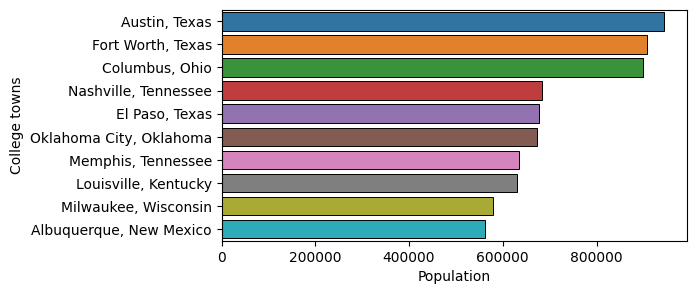

In [23]:
#plot
town_pop=town_data[['College towns','Population']].sort_values(by='Population',ascending=False)
plt.figure(figsize=(6,3))
sns.barplot(y=town_pop['College towns'][:10],x=town_pop['Population'].loc[:10],
            edgecolor='black',linewidth=0.7)
plt.show()

`Austin,Texas has the highest population of all the college towns followed by Fort Worth, Texas and the rest.`

##### 2. top 10 college towns with highest median income



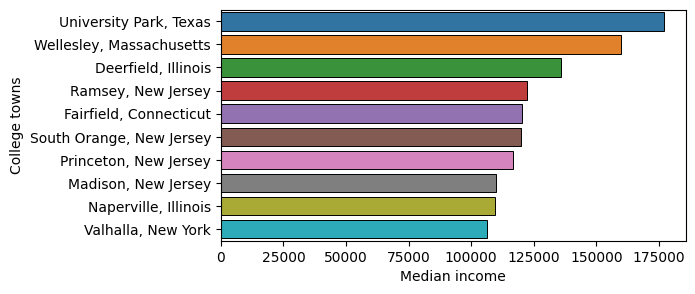

In [24]:
#plot
town_med_income=town_data[['College towns','Median income']].sort_values(by='Median income',ascending=False)
plt.figure(figsize=(6,3))
sns.barplot(y=town_med_income['College towns'][:10],x=town_med_income['Median income'].loc[:10],
            edgecolor='black',linewidth=0.7)
plt.show()

`University Park,Texas has the highest median income of all the college towns followed by Wellesley,Massachusetts and the rest.`

##### 3. college towns with lowest cost of living index




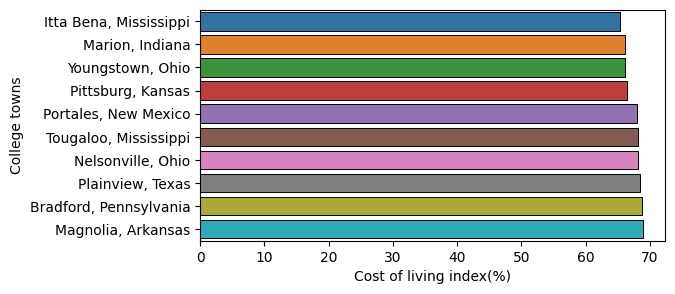

In [25]:
#plot
town_cli=town_data[['College towns','Cost of living index(%)']].sort_values(by='Cost of living index(%)',ascending=True)
plt.figure(figsize=(6,3))
sns.barplot(y=town_cli['College towns'][:10],x=town_cli['Cost of living index(%)'].loc[:10],
            edgecolor='black',linewidth=0.7)
plt.show()

`The college towns with lowest cost of living index have very similar cost of living index, with Itta Bena, Mississippi having lowest cost of living index`

In [26]:
#copy data
town_data1=town_data.copy()
#check info
town_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   College towns              800 non-null    object 
 1   Population                 800 non-null    float64
 2   Unemployment rate(%)       800 non-null    float64
 3   Median income              800 non-null    float64
 4   Median age                 800 non-null    float64
 5   Cost of living index(%)    800 non-null    float64
 6   Median download speed      800 non-null    float64
 7   Median upload speed        800 non-null    float64
 8   Median latency             800 non-null    float64
 9   Number of coworking space  800 non-null    float64
 10  Walk score                 800 non-null    float64
 11  Bike score                 800 non-null    float64
 12  Number of eateries         800 non-null    float64
dtypes: float64(12), object(1)
memory usage: 81.4+ KB


In [27]:
#create needed columns
town_data1['Number of eateries per capita']=town_data1['Number of eateries']/town_data1['Population']
town_data1['Number of coworking space per capita']=town_data1['Number of coworking space']/town_data1['Population']
town_data1['Median income per capita']=town_data1['Median income']/town_data1['Population']
town_data1['Internet speed score']=(0.5*town_data1['Median download speed'])+(0.3*town_data1['Median upload speed'])+\
                                (0.2*town_data1['Median latency'])
town_data1['Active Mobility Score']=(0.65*town_data1['Walk score'])+(0.35*town_data1['Bike score'])

In [28]:
#extract needed columns to use as metric
town_data_metric=town_data1[['College towns','Unemployment rate(%)','Cost of living index(%)','Number of eateries per capita', 
                            'Number of coworking space per capita','Median income per capita', 'Internet speed score',
                            'Active Mobility Score']]

In [29]:
#see first 5 rows
town_data_metric.head()

,College towns,Unemployment rate(%),Cost of living index(%),Number of eateries per capita,Number of coworking space per capita,Median income per capita,Internet speed score,Active Mobility Score
0,"Auburn, Alabama",2.3,97.6,0.003216,0.000027,0.501172,106.258,31.500
1,"Fairfield, Alabama",3.8,76.2,0.020627,0.000198,3.418678,100.533,32.275
2,"Florence, Alabama",3.2,79.4,0.003803,0.000050,0.897328,95.683,33.400
3,"Homewood, Alabama",1.9,114.2,0.006754,0.000153,2.382317,82.292,36.050
4,"Huntsville, Alabama",3.1,90.7,0.003399,0.000024,0.233529,153.373,29.600


### Multi-Criteria Decision Analysis

In [30]:
#setup for decision matrix object
data=town_data_metric.iloc[:,1:]
objectives=[min,min,max,max,max,max,max]
weights=[0.1,0.2,0.1,0.1,0.15,0.2,0.15]

`The weights used for each attributes:-
Unemployment rate: 10%, 
Cost of living index: 20%,
Number of eateries per capita: 10%,
Number of coworking spaces per capita: 10%,
Median income per capita: 15%,
Speed score: 20%,
Active Mobility Score: 15%`

In [31]:
#convert data to numpy array
matrix=np.array(data)
#decision matrix
decision_matrix=skc.mkdm(matrix,objectives,weights,
                        criteria=data.columns,
                        alternatives=town_data_metric['College towns'].values)
#view decision  matrix
decision_matrix

,Unemployment rate(%)[▼ 0.10],Cost of living index(%)[▼ 0.20],Number of eateries per capita[▲ 0.10],Number of coworking space per capita[▲ 0.10],Median income per capita[▲ 0.15],Internet speed score[▲ 0.20],Active Mobility Score[▲ 0.15]
"Auburn, Alabama",2.30,97.6,0.003216,0.000027,0.501172,106.258,31.500
"Fairfield, Alabama",3.80,76.2,0.020627,0.000198,3.418678,100.533,32.275
"Florence, Alabama",3.20,79.4,0.003803,0.000050,0.897328,95.683,33.400
"Homewood, Alabama",1.90,114.2,0.006754,0.000153,2.382317,82.292,36.050
"Huntsville, Alabama",3.10,90.7,0.003399,0.000024,0.233529,153.373,29.600
...,...,...,...,...,...,...,...
"River Falls, Wisconsin",4.05,85.1,0.003139,0.000044,0.613009,120.069,46.450
"Stevens Point, Wisconsin",4.10,79.9,0.004310,0.000078,1.556423,117.874,51.650
"Waukesha, Wisconsin",4.30,100.1,0.002496,0.000028,0.815151,116.798,36.050
"Whitewater, Wisconsin",4.70,86.6,0.014824,0.000070,2.107384,120.069,46.450


In [32]:
#transformation to set all objectives to maximize
inverter = invert_objectives.InvertMinimize()
decision_matrix_transformed_objectives = inverter.transform(decision_matrix)
decision_matrix_transformed_objectives

,Unemployment rate(%)[▲ 0.10],Cost of living index(%)[▲ 0.20],Number of eateries per capita[▲ 0.10],Number of coworking space per capita[▲ 0.10],Median income per capita[▲ 0.15],Internet speed score[▲ 0.20],Active Mobility Score[▲ 0.15]
"Auburn, Alabama",0.434783,0.010246,0.003216,0.000027,0.501172,106.258,31.500
"Fairfield, Alabama",0.263158,0.013123,0.020627,0.000198,3.418678,100.533,32.275
"Florence, Alabama",0.312500,0.012594,0.003803,0.000050,0.897328,95.683,33.400
"Homewood, Alabama",0.526316,0.008757,0.006754,0.000153,2.382317,82.292,36.050
"Huntsville, Alabama",0.322581,0.011025,0.003399,0.000024,0.233529,153.373,29.600
...,...,...,...,...,...,...,...
"River Falls, Wisconsin",0.246914,0.011751,0.003139,0.000044,0.613009,120.069,46.450
"Stevens Point, Wisconsin",0.243902,0.012516,0.004310,0.000078,1.556423,117.874,51.650
"Waukesha, Wisconsin",0.232558,0.009990,0.002496,0.000028,0.815151,116.798,36.050
"Whitewater, Wisconsin",0.212766,0.011547,0.014824,0.000070,2.107384,120.069,46.450


In [33]:
#apply sumscaler to bring all criteria to same scale
scaler = scalers.SumScaler(target="both")
decision_matrix_scaled = scaler.transform(decision_matrix_transformed_objectives)
decision_matrix_scaled

,Unemployment rate(%)[▲ 0.10],Cost of living index(%)[▲ 0.20],Number of eateries per capita[▲ 0.10],Number of coworking space per capita[▲ 0.10],Median income per capita[▲ 0.15],Internet speed score[▲ 0.20],Active Mobility Score[▲ 0.15]
"Auburn, Alabama",0.002755,0.001171,0.000238,0.000145,0.000143,0.001172,0.000903
"Fairfield, Alabama",0.001667,0.001500,0.001524,0.001072,0.000974,0.001109,0.000925
"Florence, Alabama",0.001980,0.001440,0.000281,0.000273,0.000256,0.001056,0.000957
"Homewood, Alabama",0.003335,0.001001,0.000499,0.000827,0.000679,0.000908,0.001033
"Huntsville, Alabama",0.002044,0.001260,0.000251,0.000129,0.000067,0.001692,0.000848
...,...,...,...,...,...,...,...
"River Falls, Wisconsin",0.001564,0.001343,0.000232,0.000240,0.000175,0.001325,0.001331
"Stevens Point, Wisconsin",0.001545,0.001431,0.000319,0.000421,0.000443,0.001300,0.001480
"Waukesha, Wisconsin",0.001473,0.001142,0.000184,0.000152,0.000232,0.001288,0.001033
"Whitewater, Wisconsin",0.001348,0.001320,0.001095,0.000377,0.000600,0.001325,0.001331


### Ranking Based on Weighted sum

```The Weighted Sum Method is a popular multi-criteria decision analysis technique used to evaluate and rank alternatives based on multiple criteria. It works by assigning weights to each criterion, which represents its relative importance, and then multiplying each criterion by its weight. The products are then summed up to produce an overall score for each alternative. The alternative with the highest score is selected as the best option. The Weighted Sum Method is simple to implement and can be used in a variety of decision-making contexts```

In [34]:
#compute ranking using Weighted Sum Model
decision = simple.WeightedSumModel()
ws_rank = decision.evaluate(decision_matrix_scaled)  # we use the tansformed version of the data
#see rank
ws_rank

Alternatives,"Auburn, Alabama","Fairfield, Alabama","Florence, Alabama","Homewood, Alabama","Huntsville, Alabama","Jacksonville, Alabama","Livingston, Alabama","Mobile, Alabama","Montevallo, Alabama","Montgomery, Alabama","Troy, Alabama","Tuscaloosa, Alabama","Tuskegee, Alabama","Anchorage, Alaska","Fairbanks, Alaska","Juneau, Alaska","Ketchikan, Alaska","Sitka, Alaska","Chandler, Arizona","Flagstaff, Arizona","Gilbert, Arizona","Glendale, Arizona","Lake Havasu City, Arizona","Mesa, Arizona","Peoria, Arizona","Prescott, Arizona","Scottsdale, Arizona","Tempe, Arizona","Tucson, Arizona","Arkadelphia, Arkansas","Conway, Arkansas","Fayetteville, Arkansas","Fort Smith, Arkansas","Jonesboro, Arkansas","Little Rock, Arkansas","Magnolia, Arkansas","Monticello, Arkansas","Russellville, Arkansas","Searcy, Arkansas","Angwin, California","Arcata, California","Azusa, California","Berkeley, California","Chico, California","Claremont, California","Cotati, California","Davis, California","Irvine, California","Isla Vista, California","La Verne, California","Loma Linda, California","Merced, California","Orange, California","Palo Alto, California","Pasadena, California","Pomona, California","Redlands, California","Riverside, California","Rocklin, California","San Luis Obispo, California","San Marcos, California","Santa Barbara, California","Santa Cruz, California","Seaside, California","Stanford, California","Turlock, California","University District, California","Whittier, California","Alamosa, Colorado","Aurora, Colorado","Boulder, Colorado","Colorado Springs, Colorado","Durango, Colorado","Fort Collins, Colorado","Golden, Colorado","Grand Junction, Colorado","Greeley, Colorado","Gunnison, Colorado","Lakewood, Colorado","Pueblo, Colorado","Bridgeport, Connecticut","Danbury, Connecticut","East Hartford, Connecticut","Fairfield, Connecticut","Farmington, Connecticut","Hamden, Connecticut","Hartford, Connecticut","Middletown, Connecticut","New Britain, Connecticut","New Haven, Connecticut","Downtown New Haven, Connecticut","New London, Connecticut","North Haven, Connecticut","Southington, Connecticut","Stamford, Connecticut","Storrs, Connecticut","Waterbury, Connecticut","Willimantic, Connecticut","West Hartford, Connecticut","West Haven, Connecticut","Dover, Delaware","Newark, Delaware","New Castle, Delaware","Wilmington, Delaware","Ave Maria, Florida","Boca Raton, Florida","Bradenton, Florida","Brandon, Florida","Cape Coral, Florida","Coral Gables, Florida","Coral Springs, Florida","Davie, Florida","Daytona Beach, Florida","DeLand, Florida","Estero, Florida","Fort Lauderdale, Florida","Fort Myers, Florida","Gainesville, Florida","Gulfport, Florida","Hialeah, Florida","Hollywood, Florida","Kendall, Florida","Lakeland, Florida","Miami Gardens, Florida","Miami Shores, Florida","Miramar, Florida","North Miami, Florida","Panama City, Florida","Pembroke Pines, Florida","Pensacola, Florida","Port St. Lucie, Florida","Sarasota, Florida","St. Augustine, Florida","St. Leo, Florida","St. Petersburg, Florida","Sunrise, Florida","Tallahassee, Florida","West Palm Beach, Florida","Albany, Georgia","Athens, Georgia","Augusta, Georgia","Blue Ridge, Georgia","Brunswick, Georgia","Carrollton, Georgia","Columbus, Georgia","Dahlonega, Georgia","Demorest, Georgia","Fort Valley, Georgia","Glennville, Georgia","Kennesaw, Georgia","Lawrenceville, Georgia","Madison, Georgia","Macon, Georgia","Milledgeville, Georgia","Mount Vernon, Georgia","Oxford, Georgia","Rome, Georgia","Savannah, Georgia","Statesboro, Georgia","Swainsboro, Georgia","Valdosta, Georgia","Vidalia, Georgia","Waleska, Georgia","Watkinsville, Georgia","Young Harris, Georgia","Laie, Hawaii","Boise, Idaho","Caldwell, Idaho","Lewiston, Idaho","Moscow, Idaho","Nampa, Idaho","Pocatello, Idaho","Rexburg, Idaho","Aurora, Illinois","Bloomington, Illinois","Bourbonnais, Illinois","Carbondale, Illinois","Champaign–Urbana metropolitan area, Illinois","Charleston, Illinois","Deerfield, Illinois","DeKalb, Illinois","D

In [35]:
#see few rank scores
ws_rank.e_.score[0:15]

array([0.00093923, 0.00123306, 0.00093433, 0.00110462, 0.00097004,
       0.00112871, 0.00180543, 0.00078193, 0.00153148, 0.00079271,
       0.00093611, 0.0008604 , 0.00119911, 0.00068256, 0.00086709])

In [36]:
#make new dataframe with metrics and scores
ranking_df=pd.DataFrame({'town':ws_rank.alternatives,'Rank':ws_rank.rank_,
              'Ranking Score':ws_rank.e_.score})

#concat with town_data_metric
college_towns_ranking_ws=pd.concat([town_data_metric,ranking_df],axis=1)

#see first 5 rows
college_towns_ranking_ws.head()

,College towns,Unemployment rate(%),Cost of living index(%),Number of eateries per capita,Number of coworking space per capita,Median income per capita,Internet speed score,Active Mobility Score,town,Rank,Ranking Score
0,"Auburn, Alabama",2.3,97.6,0.003216,0.000027,0.501172,106.258,31.500,"Auburn, Alabama",427,0.000939
1,"Fairfield, Alabama",3.8,76.2,0.020627,0.000198,3.418678,100.533,32.275,"Fairfield, Alabama",203,0.001233
2,"Florence, Alabama",3.2,79.4,0.003803,0.000050,0.897328,95.683,33.400,"Florence, Alabama",435,0.000934
3,"Homewood, Alabama",1.9,114.2,0.006754,0.000153,2.382317,82.292,36.050,"Homewood, Alabama",265,0.001105
4,"Huntsville, Alabama",3.1,90.7,0.003399,0.000024,0.233529,153.373,29.600,"Huntsville, Alabama",373,0.000970


In [37]:
#validate if towns are the same in each row
(college_towns_ranking_ws['College towns']==college_towns_ranking_ws['town']).sum()

800

In [38]:
#drop town column and then sort
college_towns_ranking_ws.drop('town',axis=1,inplace=True)

In [39]:
college_towns_ranking_ws=college_towns_ranking_ws.sort_values(by='Rank')
college_towns_ranking_ws

,College towns,Unemployment rate(%),Cost of living index(%),Number of eateries per capita,Number of coworking space per capita,Median income per capita,Internet speed score,Active Mobility Score,Rank,Ranking Score
487,"Montreat, North Carolina",4.30,121.7,0.865889,0.005831,178.571429,123.505,31.375,1,0.017933
606,"Lower Merion Township, Pennsylvania",7.90,77.8,0.254252,0.003401,72.988095,104.953,57.800,2,0.007696
486,"Misenheimer, North Carolina",4.10,76.7,0.423077,0.002849,49.857550,123.505,31.375,3,0.007661
133,"St. Leo, Florida",5.00,116.7,0.272514,0.001566,72.435395,119.080,40.000,4,0.006716
648,"Due West, South Carolina",5.40,75.2,0.384972,0.001855,44.179035,112.682,32.150,5,0.006547
...,...,...,...,...,...,...,...,...,...,...
132,"St. Augustine, Florida",4.95,109.5,0.003134,0.000018,0.440310,67.790,40.000,777,0.000710
60,"San Marcos, California",6.40,149.8,0.003973,0.000030,0.866846,104.583,31.950,778,0.000702
123,"Miami Gardens, Florida",12.70,114.4,0.001307,0.000009,0.354010,111.223,39.750,779,0.000696
13,"Anchorage, Alaska",6.60,116.0,0.002383,0.000003,0.267039,87.827,38.350,780,0.000683


### Ranking Based on Technique for Order of Preference by Similarity to Ideal Solution (TOPSIS)

```Topsis (Technique for Order of Preference by Similarity to Ideal Solution) is a multi-criteria decision analysis method used to determine the best option from a set of alternatives based on multiple criteria. It involves calculating the distance between each alternative and an ideal solution and a negative ideal solution, and then selecting the option with the shortest distance to the ideal solution and the longest distance to the negative ideal solution. Topsis is a widely used technique due to its simplicity and effectiveness in decision-making contexts.```

In [40]:
#pipeline object
pipeline = mkpipe(
    invert_objectives.NegateMinimize(),
    scalers.VectorScaler(target="matrix"),  # this scaler transform the matrix
    scalers.SumScaler(target="weights"),  # and this transform the weights
    similarity.TOPSIS())

#compute rank based on Topsis
topsis_rank = pipeline.evaluate(decision_matrix)
topsis_rank

Alternatives,"Auburn, Alabama","Fairfield, Alabama","Florence, Alabama","Homewood, Alabama","Huntsville, Alabama","Jacksonville, Alabama","Livingston, Alabama","Mobile, Alabama","Montevallo, Alabama","Montgomery, Alabama","Troy, Alabama","Tuscaloosa, Alabama","Tuskegee, Alabama","Anchorage, Alaska","Fairbanks, Alaska","Juneau, Alaska","Ketchikan, Alaska","Sitka, Alaska","Chandler, Arizona","Flagstaff, Arizona","Gilbert, Arizona","Glendale, Arizona","Lake Havasu City, Arizona","Mesa, Arizona","Peoria, Arizona","Prescott, Arizona","Scottsdale, Arizona","Tempe, Arizona","Tucson, Arizona","Arkadelphia, Arkansas","Conway, Arkansas","Fayetteville, Arkansas","Fort Smith, Arkansas","Jonesboro, Arkansas","Little Rock, Arkansas","Magnolia, Arkansas","Monticello, Arkansas","Russellville, Arkansas","Searcy, Arkansas","Angwin, California","Arcata, California","Azusa, California","Berkeley, California","Chico, California","Claremont, California","Cotati, California","Davis, California","Irvine, California","Isla Vista, California","La Verne, California","Loma Linda, California","Merced, California","Orange, California","Palo Alto, California","Pasadena, California","Pomona, California","Redlands, California","Riverside, California","Rocklin, California","San Luis Obispo, California","San Marcos, California","Santa Barbara, California","Santa Cruz, California","Seaside, California","Stanford, California","Turlock, California","University District, California","Whittier, California","Alamosa, Colorado","Aurora, Colorado","Boulder, Colorado","Colorado Springs, Colorado","Durango, Colorado","Fort Collins, Colorado","Golden, Colorado","Grand Junction, Colorado","Greeley, Colorado","Gunnison, Colorado","Lakewood, Colorado","Pueblo, Colorado","Bridgeport, Connecticut","Danbury, Connecticut","East Hartford, Connecticut","Fairfield, Connecticut","Farmington, Connecticut","Hamden, Connecticut","Hartford, Connecticut","Middletown, Connecticut","New Britain, Connecticut","New Haven, Connecticut","Downtown New Haven, Connecticut","New London, Connecticut","North Haven, Connecticut","Southington, Connecticut","Stamford, Connecticut","Storrs, Connecticut","Waterbury, Connecticut","Willimantic, Connecticut","West Hartford, Connecticut","West Haven, Connecticut","Dover, Delaware","Newark, Delaware","New Castle, Delaware","Wilmington, Delaware","Ave Maria, Florida","Boca Raton, Florida","Bradenton, Florida","Brandon, Florida","Cape Coral, Florida","Coral Gables, Florida","Coral Springs, Florida","Davie, Florida","Daytona Beach, Florida","DeLand, Florida","Estero, Florida","Fort Lauderdale, Florida","Fort Myers, Florida","Gainesville, Florida","Gulfport, Florida","Hialeah, Florida","Hollywood, Florida","Kendall, Florida","Lakeland, Florida","Miami Gardens, Florida","Miami Shores, Florida","Miramar, Florida","North Miami, Florida","Panama City, Florida","Pembroke Pines, Florida","Pensacola, Florida","Port St. Lucie, Florida","Sarasota, Florida","St. Augustine, Florida","St. Leo, Florida","St. Petersburg, Florida","Sunrise, Florida","Tallahassee, Florida","West Palm Beach, Florida","Albany, Georgia","Athens, Georgia","Augusta, Georgia","Blue Ridge, Georgia","Brunswick, Georgia","Carrollton, Georgia","Columbus, Georgia","Dahlonega, Georgia","Demorest, Georgia","Fort Valley, Georgia","Glennville, Georgia","Kennesaw, Georgia","Lawrenceville, Georgia","Madison, Georgia","Macon, Georgia","Milledgeville, Georgia","Mount Vernon, Georgia","Oxford, Georgia","Rome, Georgia","Savannah, Georgia","Statesboro, Georgia","Swainsboro, Georgia","Valdosta, Georgia","Vidalia, Georgia","Waleska, Georgia","Watkinsville, Georgia","Young Harris, Georgia","Laie, Hawaii","Boise, Idaho","Caldwell, Idaho","Lewiston, Idaho","Moscow, Idaho","Nampa, Idaho","Pocatello, Idaho","Rexburg, Idaho","Aurora, Illinois","Bloomington, Illinois","Bourbonnais, Illinois","Carbondale, Illinois","Champaign–Urbana metropolitan area, Illinois","Charleston, Illinois","Deerfield, Illinois","DeKalb, Illinois","D

In [41]:
#make new dataframe with metrics and scores based on topsis
ranking_df2=pd.DataFrame({'town':topsis_rank.alternatives,'Rank':topsis_rank.rank_})

#concat with town_data_metric
college_towns_ranking_topsis=pd.concat([town_data_metric,ranking_df2],axis=1)

#drop town column and then sort
college_towns_ranking_topsis.drop('town',axis=1,inplace=True)
# sort dataframe by ranking
college_towns_ranking_topsis=college_towns_ranking_topsis.sort_values(by='Rank')
college_towns_ranking_topsis

,College towns,Unemployment rate(%),Cost of living index(%),Number of eateries per capita,Number of coworking space per capita,Median income per capita,Internet speed score,Active Mobility Score,Rank
487,"Montreat, North Carolina",4.3,121.7,0.865889,0.005831,178.571429,123.505,31.375,1
606,"Lower Merion Township, Pennsylvania",7.9,77.8,0.254252,0.003401,72.988095,104.953,57.800,2
486,"Misenheimer, North Carolina",4.1,76.7,0.423077,0.002849,49.857550,123.505,31.375,3
133,"St. Leo, Florida",5.0,116.7,0.272514,0.001566,72.435395,119.080,40.000,4
648,"Due West, South Carolina",5.4,75.2,0.384972,0.001855,44.179035,112.682,32.150,5
...,...,...,...,...,...,...,...,...,...
42,"Berkeley, California",5.1,238.3,0.004849,0.000050,0.545813,133.840,84.300,777
722,"University Park, Texas",5.3,235.0,0.007112,0.000200,7.065244,130.610,60.300,778
61,"Santa Barbara, California",4.1,217.9,0.005116,0.000022,0.739532,96.587,63.450,779
313,"Wellesley, Massachusetts",5.8,236.0,0.002077,0.000136,5.435553,122.886,35.600,780


`From the two methods used for ranking, it can be seen that the top 13 college towns are the same for both methods, but differs from the 13th value, since both method gave similar ranking, the ranking based on weighted sum will be used as it is simple and more intuitive.`

In [42]:
#view top 10 rank based on weighted sum
college_towns_ranking_ws.iloc[0:10]

,College towns,Unemployment rate(%),Cost of living index(%),Number of eateries per capita,Number of coworking space per capita,Median income per capita,Internet speed score,Active Mobility Score,Rank,Ranking Score
487,"Montreat, North Carolina",4.3,121.7,0.865889,0.005831,178.571429,123.5050,31.375,1,0.017933
606,"Lower Merion Township, Pennsylvania",7.9,77.8,0.254252,0.003401,72.988095,104.9530,57.800,2,0.007696
486,"Misenheimer, North Carolina",4.1,76.7,0.423077,0.002849,49.857550,123.5050,31.375,3,0.007661
133,"St. Leo, Florida",5.0,116.7,0.272514,0.001566,72.435395,119.0800,40.000,4,0.006716
648,"Due West, South Carolina",5.4,75.2,0.384972,0.001855,44.179035,112.6820,32.150,5,0.006547
460,"Tivoli, New York",5.8,116.8,0.226533,0.002503,56.320401,113.5360,54.800,6,0.006229
162,"Waleska, Georgia",2.7,111.8,0.210867,0.002587,50.398448,95.6860,28.750,7,0.005888
141,"Blue Ridge, Georgia",2.8,101.5,0.139674,0.005141,24.441302,95.6860,28.750,8,0.005650
395,"Peru, Nebraska",2.2,72.6,0.108043,0.002401,48.122449,130.8725,44.400,9,0.005239
737,"Craftsbury, Vermont",4.3,92.7,0.183365,0.001890,45.218336,109.2820,66.700,10,0.005234


`The table above shows the top 10 college towns for remote workers based on the factors such as Unemployment rate, Cost of living index, Number of eateries per capita, Number of coworking spaces per capita, Median income per capita, Speed score, Active Mobility Score. it can be seen that the overall top college town is Montreat, North Carolina.`

In [43]:
#notebook end

# Get current timestamp
now = datetime.datetime.now()
# Print timestamp
print("Notebook run on:", now.strftime("%Y-%m-%d %H:%M:%S"))

Notebook run on: 2023-05-08 22:52:14
